# Deisgn of AI systems

In this assigment, we evaluate air quality of Chinese cities by building our own K-nearest neighbour class

## Assignment 3, Eric Johansson & Max Sonnelid

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [108]:
from sklearn.model_selection import train_test_split
  
# Read the CSV file.
beijing = pd.read_csv("data/Beijing_labeled.csv", skiprows=0)
chengdu = pd.read_csv("data/Chengdu_labeled.csv", skiprows=0)
guangzhou = pd.read_csv("data/Guangzhou_labeled.csv", skiprows=0)
shanghai = pd.read_csv("data/Shanghai_labeled.csv", skiprows=0)
shenyang = pd.read_csv("data/Shenyang_labeled.csv", skiprows=0)

cities = [beijing, chengdu, guangzhou, shanghai, shenyang]

In [109]:
beijing.head(1)

,season,DEWP,HUMI,PRES,TEMP,Iws,precipitation,cbwd_NE,cbwd_NW,cbwd_SE,PM_HIGH
0,4,-8.0,79.0,1026.0,-5.0,23.69,0.0,0,0,1,1.0


In [110]:
beijing_X = beijing.drop('PM_HIGH', axis =1)
beijing_Y = beijing['PM_HIGH']
chengdu_X = chengdu.drop('PM_HIGH', axis =1)
chengdu_Y = chengdu['PM_HIGH']
guangzhou_X = guangzhou.drop('PM_HIGH', axis =1)
guangzhou_Y = guangzhou['PM_HIGH']
shanghai_X = shanghai.drop('PM_HIGH', axis =1)
shanghai_Y = shanghai['PM_HIGH']
shenyang_X = shenyang.drop('PM_HIGH', axis =1)
shenyang_Y = shenyang['PM_HIGH']

In [111]:
trainData_X = beijing_X.append(shenyang_X).reset_index(drop=True)
trainData_Y = beijing_Y.append(shenyang_Y).reset_index(drop=True)

testData_X_g = guangzhou_X
testData_X_s = shanghai_X
testData_Y_g = guangzhou_Y
testData_Y_s = shanghai_Y

1352

# Data Preprocessing

In [112]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(trainData_X)
scaler2 = preprocessing.StandardScaler().fit(testData_X_g)
scaler3 = preprocessing.StandardScaler().fit(testData_X_s)

trainData_X_scaled = scaler.transform(trainData_X)
testData_X_g_scaled = scaler2.transform(testData_X_g)
testData_X_s_scaled = scaler3.transform(testData_X_s)

In [113]:
column_names = list(trainData_X.columns.values) 
print(column_names)

['season', 'DEWP', 'HUMI', 'PRES', 'TEMP', 'Iws', 'precipitation', 'cbwd_NE', 'cbwd_NW', 'cbwd_SE']


In [114]:
# Converting back to dataFrame
trainData_X_scaled = pd.DataFrame(trainData_X_scaled, columns=column_names) 
testData_X_g_scaled = pd.DataFrame(testData_X_g_scaled, columns=column_names)
testData_X_s_scaled = pd.DataFrame(testData_X_s_scaled, columns=column_names) 

1352

## Checking importance of all columns

In [115]:
from sklearn.inspection import permutation_importance

r = permutation_importance(knn, testData_X_g_scaled, testData_Y_g, n_repeats=30, random_state=0)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{column_names[i]:<8}" 
        f"{r.importances_mean[i]:.3f}"
        f" +/- {r.importances_std[i]:.3f}")

TEMP    0.040 +/- 0.008
DEWP    0.032 +/- 0.006
PRES    0.023 +/- 0.007
season  0.014 +/- 0.006


Dropping columns that are not important

In [101]:
data = [trainData_X_scaled,testData_X_s_scaled, testData_X_g_scaled]

In [116]:
selected_cols = ['TEMP', 'DEWP', 'PRES', 'season']
trainData_X_scaled = trainData_X_scaled[selected_cols]
testData_X_s_scaled = testData_X_s_scaled[selected_cols]
testData_X_g_scaled = testData_X_g_scaled[selected_cols]


In [137]:
import math
import operator

class own_knn:

    def __init__(self, neighbors):
        self.neighbors = neighbors
        self.notFitted = False

    def euclidean_dist(self, r1, r2):
        sum = 0

        if (len(r1) != len(r2)):
            raise ValueError("Both vectors must have the same lenght in order to calculate distance")

        for i in range(len(r1)-1):
            sum = sum + (r1[i] - r2[i])**2
        
        return math.sqrt(sum)
    

    def get_neighbours(self, point, dataset, labelset, no_neighb):
        arr = [[]] * 0

        res = []

        for i in range(len(dataset)):
            arr.append([i, self.euclidean_dist(point,dataset.iloc[i])])
        
        arr.sort(key=operator.itemgetter(1))

        for i in range(no_neighb):
            res.append(labelset.iloc[arr[i][0]])

        return res


    def fit(self, X, Y):
        self.trainData = X
        self.trainLabels = Y
        if (len( self.trainData)!=len( self.trainLabels)):
            raise ValueError("Both vectors must have the same lenght in order to fit model")
        
        self.notFitted = False
        return self
    

    def predict(self,x_test):
        res = [[]] * 0

        for i in range(len(x_test)):
            res.append([i, np.bincount(self.get_neighbours(x_test.iloc[i],self.trainData,self.trainLabels,self.neighbors)).argmax()])
        
        return res
    
    def score(self,predict,y_test):
        sum = 0
        for i in range(len(predict)-1):
            if (predict[i][1] == y_test.iloc[i]):
                sum = sum + 1
        
        acc = sum / len(predict)

        return acc



In [138]:
import time

running_time = 0
obj = own_knn(5)

start = time.time()
obj.fit(trainData_X_scaled,trainData_Y)

res_xTrain = obj.predict(trainData_X_scaled)
res_xTest_s = obj.predict(testData_X_s_scaled)
res_xTest_g = obj.predict(testData_X_g_scaled)
stop = time.time()
print(f"Prediction time: {stop-start}s")


Prediction time: 1402.875611782074s


In [142]:
len(testData_Y)

2703

In [145]:
f"Prediction time: {stop-start}s"

print(f"Score on training data: {obj.score(res_xTrain,trainData_Y)}")
print(f"Score on Guangzhou data: {obj.score(res_xTest_g,testData_Y_g)}")
print(f"Score on Shanghai data: {obj.score(res_xTest_s,testData_Y_s)}")

Score on training data: 0.8100172711571675
Score on Guangzhou data: 0.7544378698224852
Score on Shanghai data: 0.7253886010362695


## Benchmark with knn classifier from skLearn

In [194]:
from sklearn.neighbors import KNeighborsClassifier
import time

knn = KNeighborsClassifier(5,weights='uniform',metric='euclidean') 

#Train the model using the training sets
knn.fit(trainData_X_scaled, trainData_Y)

start = time.time()
score = knn.score(testData_X_s_scaled,testData_Y_s)

stop = time.time()
print(f"Prediction time: {stop-start}s")
print(f"Prediction score: {score}s")

Prediction time: 0.030073881149291992s
Prediction score: 0.7290895632864545s


## Benchmark with dummy classifier

In [55]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(trainData_X_scaled, trainData_Y)
dummy_clf.predict(testData_X_scaled)
dummy_clf.score(testData_X_scaled, testData_Y)

0.9189789123196448

Since the result of the dummyClassifier is higher than any other model, we plot a confusion matrix in order to learn more about the predictions. Here, it is interesting to see the share of true-positive and false-negative. 

## Confusion matrix

In [190]:
B = np.asmatrix(res_xTest_g)
C = B[:,1]
D = np.asarray(C)
print(D)

[[0]
 [0]
 [0]
 ...
 [0]
 [1]
 [0]]


## Result when testing on Guangzhou data

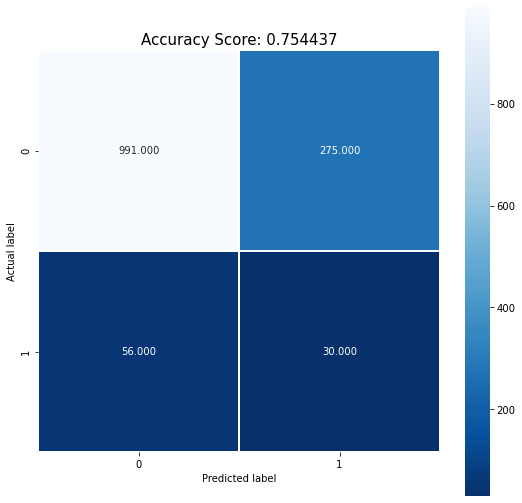

In [193]:
cm = metrics.confusion_matrix(testData_Y_g, D)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format('0.754437')
plt.title(all_sample_title, size = 15);
plt.savefig('toy_Digits_ConfusionSeabornCodementor.png')
#plt.show();

In [196]:
B = np.asmatrix(res_xTest_s)
C = B[:,1]
D = np.asarray(C)
print(D)

[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


## Result when testing on Shanghai data

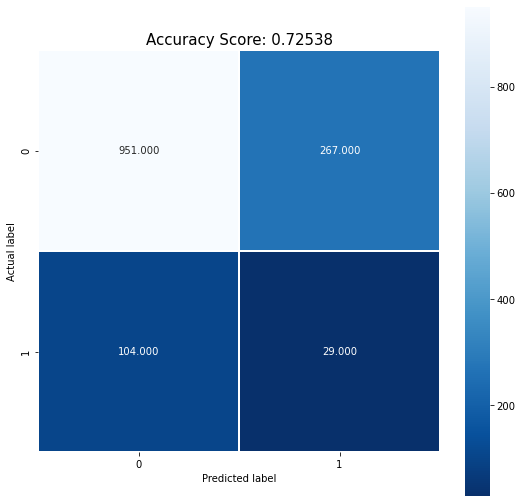

In [197]:
cm = metrics.confusion_matrix(testData_Y_s, D)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format('0.72538')
plt.title(all_sample_title, size = 15);
plt.savefig('toy_Digits_ConfusionSeabornCodementor.png')
#plt.show();